<a href="https://colab.research.google.com/github/korkutanapa/ANOMALY_DETECTION_TDA_YAHOO_DATASET/blob/main/anomaly_detection_for_nab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
# @title necessary libraries
# Install
#!pip install -U "numpy>=2.0,<2.3" "scipy>=1.11" ripser persim

In [156]:
import warnings
# Option A – ignore ALL DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Shape: (4032, 1)
                     value
timestamp                 
2014-02-14 14:30:00  0.132
2014-02-14 14:35:00  0.134
2014-02-14 14:40:00  0.134
2014-02-14 14:45:00  0.134
2014-02-14 14:50:00  0.134

Describe:
count    4032.000000
mean        0.126303
std         0.094813
min         0.066000
25%         0.132000
50%         0.134000
75%         0.134000
max         2.344000
Name: value, dtype: float64


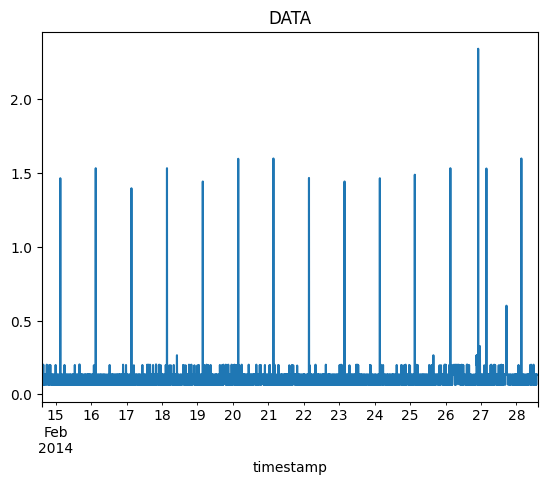

In [157]:
# @title reading the NAB file

import pandas as pd
from pathlib import Path

CSV_PATH = '/content/ec2_cpu_utilization_24ae8d.csv'
# The original data file from the NAB dataset (Must exist on disk)
DATA_FILE_PATH = CSV_PATH
LABELS_JSON = '/content/combined_windows.json'
# The file name relative to the NAB data structure (used to look up labels)
NAB_DATASET_KEY = '/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv'
LABEL_FILE_PATH = '/content/combined_windows.json'
# Where to save your synthetic results
OUTPUT_RESULT_FILE = 'output.csv'

# 1) Basic existence check (nice for Colab)
p = Path(CSV_PATH)
if not p.exists():
    raise FileNotFoundError(f"File not found: {CSV_PATH}")

# 2) Read CSV
# NAB Twitter volume files typically have: timestamp,value
# If columns differ, we handle it gracefully below.
df = pd.read_csv(
    CSV_PATH,
    parse_dates=["timestamp"],   # parse timestamp to datetime
    infer_datetime_format=True
)

# 3) Standardize column names (lowercase, no spaces) just in case
df.columns = [c.strip().lower() for c in df.columns]

# 4) Identify the value column (usually 'value')
if "value" in df.columns:
    value_col = "value"
else:
    # Fallback: pick the first numeric column that isn't 'timestamp' or 'anomaly'
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in ("anomaly",)]
    value_col = numeric_cols[0] if numeric_cols else None

if "timestamp" not in df.columns or value_col is None:
    raise ValueError(f"Unexpected columns: {df.columns.tolist()} — couldn't find timestamp/value.")

# 5) Optional: set index
df = df.set_index("timestamp").sort_index()

# 6) Quick peek
print("Shape:", df.shape)
print(df.head())
print("\nDescribe:")
print(df[value_col].describe())

# 7) Optional: quick plot (uncomment if you want a chart)
import matplotlib.pyplot as plt
df[value_col].plot(title="DATA")
plt.show()


In [158]:
# @title reading NAB anomaly

# --- 2) Load NAB label windows and mark each row as anomalous (0/1) ---
import json
from pathlib import Path
import pandas as pd
import numpy as np




# Read data
df = pd.read_csv(CSV_PATH, parse_dates=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

# Read window labels
with open(LABELS_JSON, "r") as f:
    labels = json.load(f)

# Find the key in combined_windows.json that corresponds to this file.
# In NAB, keys look like "realTweets/Twitter_volume_AAPL.csv"
csv_name = Path(CSV_PATH).name
matching_keys = [k for k in labels.keys() if k.endswith(csv_name)]

if not matching_keys:
    print(f"No label windows found for {csv_name}. Adding is_anomaly=0.")
    df["is_anomaly"] = 0
else:
    key = matching_keys[0]
    windows = labels[key]

    # Normalize possible window formats (dicts or 2-item lists)
    def _to_bounds(w):
        if isinstance(w, dict):
            s, e = w.get("start"), w.get("end")
        else:
            s, e = w[0], w[1]
        return pd.to_datetime(s), pd.to_datetime(e)

    bounds = [ _to_bounds(w) for w in windows ]

    # Initialize label column
    is_anom = np.zeros(len(df), dtype=int)

    # Mark 1 for timestamps within any labeled window (inclusive)
    ts = df["timestamp"].values
    for s, e in bounds:
        mask = (df["timestamp"] >= s) & (df["timestamp"] <= e)
        is_anom[mask.values if hasattr(mask, "values") else mask] = 1

    df["is_anomaly"] = is_anom

# Inspect
print(df.head())
print("Anomaly points:", int(df["is_anomaly"].sum()), "of", len(df))

            timestamp  value  is_anomaly
0 2014-02-14 14:30:00  0.132           0
1 2014-02-14 14:35:00  0.134           0
2 2014-02-14 14:40:00  0.134           0
3 2014-02-14 14:45:00  0.134           0
4 2014-02-14 14:50:00  0.134           0
Anomaly points: 402 of 4032


In [159]:
import pandas as pd

# assume your original dataframe is named df and has columns:
# ['timestamp', 'value', 'is_anomaly']

# 1) Drop timestamp
df = df.drop(columns=["timestamp"])

# 2) Rename 'value' -> 'y'
df = df.rename(columns={"value": "y"})

# 3) Add index and t columns (0,1,2,...,N-1)
df = df.reset_index(drop=True)
df["index"] = df.index
df["t"] = df.index

# 4) Reorder columns to: index, t, y, is_anomaly
df = df[["index", "t", "y", "is_anomaly"]]

print(df.head())


   index  t      y  is_anomaly
0      0  0  0.132           0
1      1  1  0.134           0
2      2  2  0.134           0
3      3  3  0.134           0
4      4  4  0.134           0


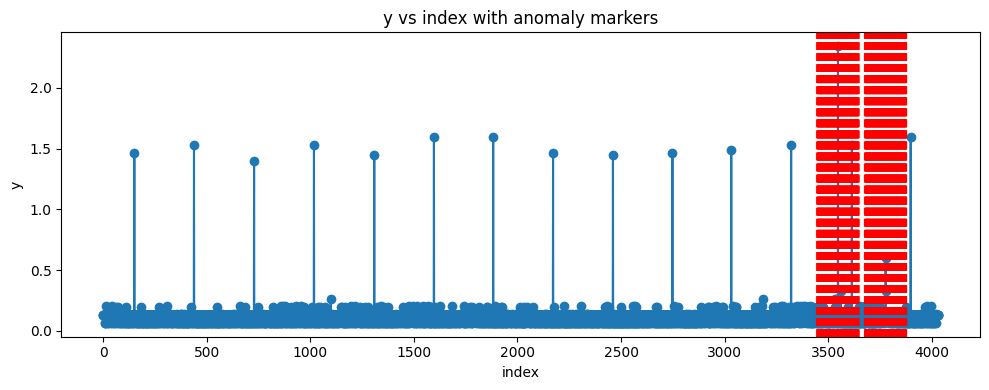

In [160]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot y vs indices
plt.figure(figsize=(10, 4))
plt.plot(df["index"], df["y"], marker="o")
plt.xlabel("index")
plt.ylabel("y")
plt.title("y vs index with anomaly markers")

# Add vertical dashed lines where is_anomaly == 1
anomaly_indices = df.loc[df["is_anomaly"] == 1, "index"]

for idx in anomaly_indices:
    plt.axvline(x=idx, linestyle="--", color="red", alpha=0.7)

plt.tight_layout()
plt.show()


In [161]:
# @title finding tda dimension
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors

# ------------------------------
# Helper utilities
# ------------------------------
def _to_1d_array(ts):
    x = np.asarray(ts, dtype=float).ravel()
    if np.isnan(x).any():
        med = np.nanmedian(x)
        x = np.where(np.isnan(x), med, x)
    return x

def time_delay_embed(x, m, tau=1):
    """
    Return embedding with aligned indexing: shape (L, m) where
    L = N - (m-1)*tau. Assumes tau >= 1 and len(x) >= m.
    """
    x = _to_1d_array(x)
    N = x.size
    L = N - (m - 1) * tau
    if L <= 1:
        raise ValueError("Time series too short for the requested (m, tau).")
    return np.column_stack([x[i:i + L] for i in range(0, m * tau, tau)])

def _nearest_neighbor_distances(X):
    """
    For each row in X, get distance to its nearest neighbor (excluding self)
    and the neighbor's index.
    """
    nn = NearestNeighbors(n_neighbors=2, algorithm="kd_tree").fit(X)
    dists, idxs = nn.kneighbors(X, n_neighbors=2, return_distance=True)
    # first neighbor is self (distance 0), second is the true NN
    Rm = dists[:, 1]
    nn_idx = idxs[:, 1]
    return Rm, nn_idx

def false_nearest_neighbors_ratio(ts,
                                  m,
                                  tau=1,
                                  r_tol=10.0,
                                  a_tol=2.0,
                                  sample_size=4000,
                                  random_state=0):
    """
    Compute FNN ratio for a SINGLE dimension m (i.e., testing m -> m+1).
    Uses KD-tree NN and optional subsampling for speed.
    """
    x = _to_1d_array(ts)
    # Build (m+1)-dim embedding once; slice Xm and Xm1 with shared length
    Xm1_full = time_delay_embed(x, m + 1, tau)          # (L, m+1)
    L = Xm1_full.shape[0]
    Xm_full = Xm1_full[:, :m]                           # (L, m)

    # Subsample to control complexity
    rng = np.random.default_rng(random_state)
    if L > sample_size:
        sel = np.sort(rng.choice(L, size=sample_size, replace=False))
        Xm  = Xm_full[sel]
        Xm1 = Xm1_full[sel]
    else:
        Xm  = Xm_full
        Xm1 = Xm1_full
        sel = None

    # NN in m-dim
    Rm, nn_idx = _nearest_neighbor_distances(Xm)

    # Distance to same neighbor in (m+1)-dim
    diffs = Xm1 - Xm1[nn_idx]
    Rm1 = np.linalg.norm(diffs, axis=1)

    # Kennel et al. criteria
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.where(Rm > 0, np.abs(Rm1 - Rm) / Rm, np.inf)
    crit1 = ratio > r_tol

    A = np.std(x) if np.std(x) > 0 else 1.0
    crit2 = (Rm1 / A) > a_tol

    fnn = np.sum(crit1 | crit2)
    return fnn / Rm.shape[0]

def pick_dimension_fixed_window(ts,
                                window_size,
                                tau=1,
                                fnn_threshold=0.01,
                                max_dim=None,
                                r_tol=10.0,
                                a_tol=2.0,
                                sample_size=4000,
                                random_state=0):
    """
    With fixed window_size and tau=1,stride=1, choose the smallest m
    such that FNN% < threshold, constrained by (m-1)*tau+1 <= window_size.
    NOTE: for tau=1, the strict Takens sliding-window length equals m.
    If you use a *separate* spectral window of 250, this function still
    caps m so (m-1)*tau+1 <= window_size.
    """
    x = _to_1d_array(ts)
    assert tau == 1, "This function is configured for tau=1."
    m_cap = window_size  # since (m-1)*tau+1 <= window_size  ==> m <= window_size for tau=1
    if max_dim is None:
        # practical bound (don’t try up to 250; FNN is costly). You can raise if you wish.
        max_dim = min(30, m_cap)

    fnn_ratios = []
    candidate_ms = list(range(1, max_dim))  # evaluate m=1..max_dim-1 (test m->m+1)
    for m in candidate_ms:
        r = false_nearest_neighbors_ratio(
            ts=x, m=m, tau=tau,
            r_tol=r_tol, a_tol=a_tol,
            sample_size=sample_size,
            random_state=random_state
        )
        fnn_ratios.append(r)

        if r < fnn_threshold:
            # Smallest m meeting criterion → embedding dimension = m
            return {
                "dimension": m,
                "window_size": window_size,
                "tau": tau,
                "fnn_ratios": pd.Series(fnn_ratios, index=[k for k in candidate_ms[:len(fnn_ratios)]])
            }

    # If none fell below threshold, pick argmin+1 (Kennel heuristic)
    best_m = int(np.argmin(fnn_ratios) + 1)
    return {
        "dimension": best_m,
        "window_size": window_size,
        "tau": tau,
        "fnn_ratios": pd.Series(fnn_ratios, index=[k for k in candidate_ms[:len(fnn_ratios)]])
    }

# ------------------------------
# Example usage
# ------------------------------
# df = pd.read_csv("your_file.csv")
ts = df["y"].values
result = pick_dimension_fixed_window(
     ts,
     window_size=20,    # FIXED
     tau=1,              # FIXED time delay
     fnn_threshold=0.01,
     max_dim=30,         # you can increase (trade-off: runtime)
     r_tol=10.0,
     a_tol=2.0,
     sample_size=4000,   # ~ speeds up on 15.9k points
     random_state=0
 )
print(result["dimension"], result["window_size"], result["tau"])
print(result["fnn_ratios"])
# ---------------- Tunables ----------------
WINDOW_SIZE = result["window_size"]
TAU         = result["tau"]
DIMENSION   = result["dimension"]  # you can change this if you want


22 20 1
1     0.99850
2     0.99225
3     0.97500
4     0.94075
5     0.86225
6     0.76025
7     0.63225
8     0.49025
9     0.40100
10    0.34250
11    0.28675
12    0.25075
13    0.21500
14    0.19050
15    0.16775
16    0.13925
17    0.10775
18    0.08500
19    0.06950
20    0.05650
21    0.05350
22    0.05175
23    0.05400
24    0.06175
25    0.06975
26    0.08625
27    0.10325
28    0.11975
29    0.13050
dtype: float64


In [162]:
DIMENSION = 6

In [163]:
import numpy as np
import pandas as pd
from ripser import ripser
import warnings

# ==========================================================
# 1. SETUP & PARAMETERS
# ==========================================================

FEATURE_NAMES = [
    "H0_ratio_auc_L1_to_sum", "H0_ratio_auc_to_max", "H0_ratio_auc_to_l2",
    "H0_bottleneck", "tail_share_q90", "H0_sum_centroid",
    "H0_L2_norm", "PETE_p1.6_q0.5", "H0_energy_concentration",
    "H0_dominance_share", "H0_tail_curvature_80_90",
    "H0_centroid_to_energy", "H0_gini",
]

# ==========================================================
# 2. TDA UTILITY FUNCTIONS (Same as before)
# ==========================================================
def takens_embed(window: np.ndarray, tau: int, m: int) -> np.ndarray:
    L = len(window) - (m - 1) * tau
    if L <= 0: raise ValueError(f"Window too short: {len(window)}")
    return np.stack([window[j : j + L * tau : tau] for j in range(m)], axis=1)

def _clean_diag_h(diag_h):
    if diag_h is None: return np.empty((0, 2), dtype=float)
    arr = np.asarray(diag_h, dtype=float)
    if arr.ndim != 2 or arr.shape[1] != 2 or arr.size == 0:
        return np.empty((0, 2), dtype=float)
    finite_mask = np.isfinite(arr).all(axis=1)
    arr = arr[finite_mask]
    if arr.size == 0: return np.empty((0, 2), dtype=float)
    b, d = arr[:, 0], arr[:, 1]
    ok = np.isfinite(d) & (d > b)
    if not np.any(ok): return np.empty((0, 2), dtype=float)
    return np.stack([b[ok], d[ok]], axis=1)

try: _trapz = np.trapezoid
except AttributeError: _trapz = np.trapz

_EPS = 1e-12
def _safe_div(a, b): return float(a) / float(b + _EPS)

def _lifetimes(arr):
    return np.maximum(arr[:, 1] - arr[:, 0], 0.0) if arr.size else np.empty((0,), float)

def _bottleneck_amp(arr):
    L = _lifetimes(arr)
    return float(np.max(L)) if L.size else 0.0

def h0_l2_norm(arr):
    L = _lifetimes(arr)
    return float(np.sqrt(np.sum(L**2))) if L.size else 0.0

def _auc_tri_max(arr):
    if arr.size == 0: return 0.0
    if arr.shape[0] == 1: return 0.25 * ((arr[0, 1] - arr[0, 0])**2)

    # Simple grid approximation for AUC
    n_grid = 64
    lo, hi = (float(np.min(arr[:, 0])), float(np.max(arr[:, 1]))) if arr.size else (0.0, 1.0)
    grid = np.linspace(lo, hi, num=n_grid)
    lam1 = np.zeros_like(grid, float)

    b, d = arr[:, 0], arr[:, 1]
    for bj, dj in zip(b, d):
        m = 0.5 * (bj + dj)
        h = 0.5 * (dj - bj)
        if h <= 0: continue

        # Vectorized triangle update
        mask = (grid >= bj) & (grid <= dj)
        if not mask.any(): continue

        # Left side of triangle
        l_mask = mask & (grid <= m)
        if l_mask.any():
            lam1[l_mask] = np.maximum(lam1[l_mask], (grid[l_mask] - bj) * (h / (m - bj + _EPS)))

        # Right side of triangle
        r_mask = mask & (grid > m)
        if r_mask.any():
            lam1[r_mask] = np.maximum(lam1[r_mask], (dj - grid[r_mask]) * (h / (dj - m + _EPS)))

    return float(_trapz(lam1, grid))

def compute_h0_features_for_window(window: np.ndarray) -> dict:
    emb = takens_embed(window, TAU, DIMENSION)
    dgms = ripser(emb, maxdim=0)["dgms"]
    D0 = _clean_diag_h(dgms[0] if len(dgms) else None)

    # Helpers for features
    L = _lifetimes(D0)
    S = float(L.sum())
    A = _auc_tri_max(D0)
    L2 = h0_l2_norm(D0)
    mx = float(np.max(L)) if L.size else 0.0

    # Calculate Features
    feats = {}
    feats["H0_ratio_auc_L1_to_sum"]  = 0.0 if S <= _EPS else A / S
    feats["H0_ratio_auc_to_max"]     = 0.0 if mx <= _EPS else A / mx
    feats["H0_ratio_auc_to_l2"]      = 0.0 if L2 <= _EPS else A / L2
    feats["H0_bottleneck"]           = mx

    # Tail share q90
    if S > _EPS:
        qv = float(np.quantile(L, 0.90))
        feats["tail_share_q90"] = float(L[L >= qv].sum()) / S
    else:
        feats["tail_share_q90"] = 0.0

    # Centroid
    if S > _EPS:
        radial = np.abs((D0[:,0] + D0[:,1]) / np.sqrt(2.0))
        feats["H0_sum_centroid"] = float(np.sum(radial * L)) / S
    else:
        feats["H0_sum_centroid"] = 0.0

    feats["H0_L2_norm"] = L2

    # PETE
    if S > _EPS:
        radial = (D0[:,0] + D0[:,1]) / np.sqrt(2.0)
        num = np.sum((L ** 1.6) * (np.abs(radial) ** 0.5))
        feats["PETE_p1.6_q0.5"] = num / S
    else:
        feats["PETE_p1.6_q0.5"] = 0.0

    feats["H0_energy_concentration"] = (L2 / S) if S > _EPS else 0.0
    feats["H0_dominance_share"]      = (mx / S) if S > _EPS else 0.0

    # Curvature
    if S > _EPS:
        q90 = float(L[L >= np.quantile(L, 0.90)].sum()) / S
        q80 = float(L[L >= np.quantile(L, 0.80)].sum()) / S
        feats["H0_tail_curvature_80_90"] = q90 - q80
    else:
        feats["H0_tail_curvature_80_90"] = 0.0

    feats["H0_centroid_to_energy"]   = (feats["H0_sum_centroid"] / L2) if L2 > _EPS else 0.0

    # Gini
    if L.size > 0 and S > _EPS:
        xs = np.sort(L)
        n = xs.size
        cumx = np.cumsum(xs)
        feats["H0_gini"] = float(1.0 + 1.0/n - 2.0 * (cumx.sum() / (n * S)))
    else:
        feats["H0_gini"] = 0.0

    return feats

# ==========================================================
# 3. MAIN EXECUTION (CORRECTED DATA HANDLING)
# ==========================================================

# Correctly handle 'ts' regardless of if it's a DataFrame or Array
if isinstance(ts, pd.DataFrame):
    ts_values = ts["y"].values.astype(float)
    timestamps = ts["t"].values
elif isinstance(ts, np.ndarray):
    # If ts is just the values array
    ts_values = ts.astype(float)
    # Generate dummy indices matching the length
    timestamps = np.arange(len(ts))
else:
    # Fallback: try to find 'df' in global scope
    try:
        ts_values = df["y"].values.astype(float)
        timestamps = df["t"].values
    except NameError:
        raise ValueError("Could not find 'ts' or 'df'. Please ensure data is loaded.")

tda_results = []

print(f"Calculating features (Dim={DIMENSION}, Win={WINDOW_SIZE})... Points: {len(ts_values)}")

for i in range(len(ts_values)):
    row_result = {"t": timestamps[i]}

    # Only calculate if we have enough history for the window
    if i < WINDOW_SIZE - 1:
        for name in FEATURE_NAMES:
            row_result[name] = np.nan
    else:
        # Extract window: from (i - window + 1) to (i + 1)
        window = ts_values[i - WINDOW_SIZE + 1 : i + 1]

        try:
            feats = compute_h0_features_for_window(window)
            row_result.update(feats)
        except Exception:
            for name in FEATURE_NAMES: row_result[name] = 0.0

    tda_results.append(row_result)

# Create final DataFrame
tda_df = pd.DataFrame(tda_results)
print("Calculation complete.")


Calculating features (Dim=6, Win=20)... Points: 4032
Calculation complete.


In [164]:
import numpy as np
import pandas as pd

# ==========================================================
# 1. VEAD CONFIGURATION & FUNCTION
# ==========================================================
# Parameters for sensitivity
KV   = 3.5  # Velocity gain
KA   = 3.5  # Acceleration gain
MODE = "abs_plateau"  # "strict" | "plateau" | "abs_plateau"

def _vead_series(raw_vals, kv=KV, ka=KA, mode=MODE):
    """
    Compute VEAD score for a 1D array-like series.
    Logic: Combines normalized Velocity (1st deriv) and Acceleration (2nd deriv).
    """
    # 1. Interpolate to handle NaNs (common in TDA start windows)
    s = pd.to_numeric(pd.Series(raw_vals, dtype=float), errors="coerce") \
            .interpolate(limit_direction="both")

    # 2. Compute Derivatives
    v = s.diff(1)  # Velocity
    a = v.diff(1)  # Acceleration

    # 3. Z-Score using MAD (Median Absolute Deviation) for robustness
    def _zmad(x):
        med = np.nanmedian(x)
        mad = np.nanmedian(np.abs(x - med)) + 1e-12
        return (x - med) / mad

    zv = _zmad(v.values)
    za = _zmad(a.values)

    # 4. Apply Mode Logic
    mode = (mode or "strict").lower()
    if mode == "strict":
        # Only positive shocks
        zv = np.maximum(0.0, zv)
        za = np.maximum(0.0, za)
    elif mode == "plateau":
        # Allow small negative dips, silence large negative drops
        zv = np.where(zv > -0.25, zv, 0.0)
        za = np.where(za > -0.25, za, 0.0)
    elif mode == "abs_plateau":
        # Absolute magnitude of shock (good for detecting both spikes and drops)
        zv = np.abs(zv)
        za = np.abs(za)

    # 5. Final Score Calculation
    score = (kv * zv) * (ka * za)

    # Clean up NaNs/Infs (created by diff at index 0 and 1)
    return np.nan_to_num(score, nan=0.0, posinf=0.0, neginf=0.0)

# ==========================================================
# 2. APPLY VEAD TO TDA_DF
# ==========================================================

# Ensure tda_df exists
if 'tda_df' not in locals():
    raise ValueError("tda_df not found. Please calculate TDA features first.")

# Identify feature columns (exclude metadata like 't', 'index', 'is_anomaly')
metadata_cols = ['t', 'index', 'is_anomaly']
feature_cols = [c for c in tda_df.columns if c not in metadata_cols]

print(f"Applying VEAD (Mode={MODE}) to {len(feature_cols)} features...")

# Create a dictionary to hold the new columns. Start with 't'.
vead_data = {'t': tda_df['t'].values}

for col in feature_cols:
    # 1. Get raw TDA feature
    raw_values = tda_df[col].values

    # 2. Calculate VEAD score
    vead_scores = _vead_series(raw_values, kv=KV, ka=KA, mode=MODE)

    # 3. Store with new name
    vead_data[f"VEAD__{col}"] = vead_scores

# Create the final DataFrame
vead_df = pd.DataFrame(vead_data)

# ==========================================================
# 3. DISPLAY RESULTS
# ==========================================================
print("VEAD Calculation Complete.")
print(f"Shape: {vead_df.shape}")
print(vead_df.head())



Applying VEAD (Mode=abs_plateau) to 13 features...
VEAD Calculation Complete.
Shape: (4032, 14)
   t  VEAD__H0_ratio_auc_L1_to_sum  VEAD__H0_ratio_auc_to_max  \
0  0                           0.0                        0.0   
1  1                           0.0                        0.0   
2  2                           0.0                        0.0   
3  3                           0.0                        0.0   
4  4                           0.0                        0.0   

   VEAD__H0_ratio_auc_to_l2  VEAD__H0_bottleneck  VEAD__tail_share_q90  \
0                       0.0                  0.0                   0.0   
1                       0.0                  0.0                   0.0   
2                       0.0                  0.0                   0.0   
3                       0.0                  0.0                   0.0   
4                       0.0                  0.0                   0.0   

   VEAD__H0_sum_centroid  VEAD__H0_L2_norm  VEAD__PETE_p1.6_q0.5  \


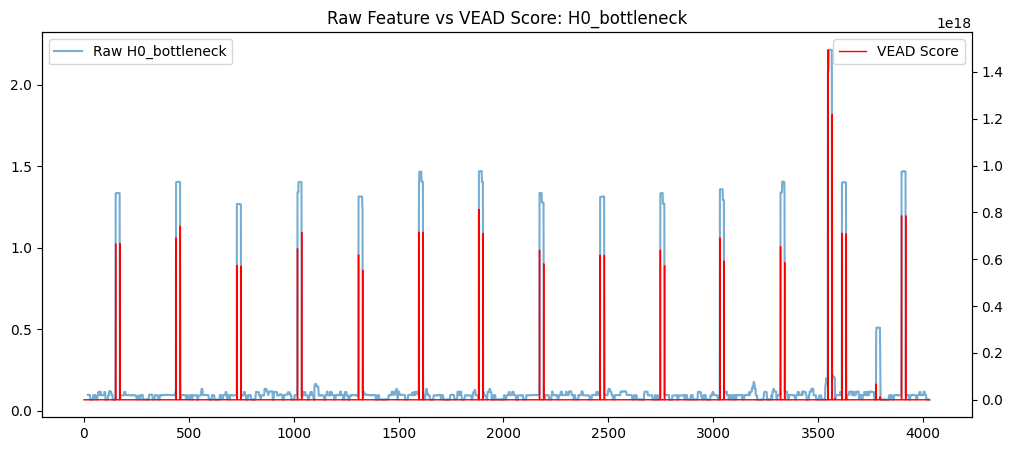

In [165]:
# Optional: Visualize one feature vs its VEAD score
try:
    import matplotlib.pyplot as plt

    # Pick the first feature to plot
    demo_feat = feature_cols[3]
    demo_vead = f"VEAD__{demo_feat}"

    plt.figure(figsize=(12, 5))
    plt.plot(tda_df['t'], tda_df[demo_feat], label=f"Raw {demo_feat}", alpha=0.6)
    # Plot VEAD on secondary axis or scaled? Let's just normalize to visualize overlay
    # Or just plot on twin axis
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax2.plot(vead_df['t'], vead_df[demo_vead], color='red', label="VEAD Score", linewidth=1)

    ax1.set_title(f"Raw Feature vs VEAD Score: {demo_feat}")
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()
except ImportError:
    pass

In [167]:
import pandas as pd
import numpy as np
from scipy.stats import genpareto
import json
import os
import math
import itertools
import warnings

# Suppress warnings for cleaner output during optimization
warnings.filterwarnings("ignore")

# ==========================================
# 0. CONFIGURATION & FILE SETUP
# ==========================================
# Ensure these match your environment exactly
#DATA_FILE_PATH = '/content/exchange-2_cpc_results.csv'
#LABEL_FILE_PATH = '/content/combined_windows.json'
#NAB_DATASET_KEY = 'realAdExchange/exchange-2_cpc_results.csv'

# Optimization Grid
# We will test all combinations of these values
# Expanded search depth for finer granularity and wider range
GRID_Q = [
    0.85, 0.88, 0.90, 0.92, 0.94, 0.95,
    0.96, 0.97, 0.98, 0.985, 0.99, 0.995, 0.999
]

GRID_RISK = [
    1e-1, 5e-2, 1e-2, 5e-3, 2e-3, 1e-3,
    5e-4, 2e-4, 1e-4, 5e-5, 1e-5, 1e-6
]

# ==========================================
# 1. CORE ALGORITHM: EVT (Do not change)
# ==========================================
def get_evt_anomaly_indices(series, initial_threshold_q, risk):
    data = series.dropna().values
    if len(data) == 0: return []

    u = np.quantile(data, initial_threshold_q)
    excesses = data[data > u] - u

    if len(excesses) < 5: return []

    try:
        shape, loc, scale = genpareto.fit(excesses, floc=0)

        if abs(shape) < 1e-9: shape = 1e-9

        N = len(data)
        Nt = len(excesses)
        tail_prob = 1 - (risk * (N / Nt))

        if tail_prob > 1 or tail_prob < 0:
            final_threshold = np.max(data) + 1e-6
        else:
            excess_threshold = genpareto.ppf(tail_prob, shape, loc=0, scale=scale)
            final_threshold = u + excess_threshold

        anomalies = series[series > final_threshold]
        return anomalies.index.tolist()
    except Exception:
        return []

# ==========================================
# 2. CORE ALGORITHM: NAB SCORER (Optimized for Loop)
# ==========================================
# Helper to avoid repetitive file I/O inside the loop
def scaled_sigmoid(relative_position):
    if relative_position > 1.0: return -1.0
    return 2.0 / (1.0 + math.exp(5.0 * relative_position))

def get_nab_score_memory(indices, timestamps, windows):
    """
    In-memory version of your NAB scorer.
    Calculates score without writing/reading CSVs to disk to save time.
    """
    if not indices:
        return 0.0 # No anomalies found

    # Create a simplified detection series
    detections = pd.DataFrame({'timestamp': timestamps})
    detections['anomaly_score'] = 0

    # Map indices to timestamps
    # Assuming indices correspond to the rows in timestamps
    valid_indices = [i for i in indices if i < len(detections)]
    if not valid_indices:
        return 0.0

    detections.loc[valid_indices, 'anomaly_score'] = 1

    # Filter to only rows with anomalies
    detections = detections[detections['anomaly_score'] > 0]

    # NAB Parameters
    A_TP = 1.0
    A_FP = -0.11
    A_FN = -1.0

    raw_score = 0.0
    detected_windows = [False] * len(windows)
    detection_used = [False] * len(detections)

    for i, (start_str, end_str) in enumerate(windows):
        start_dt = pd.to_datetime(start_str)
        end_dt = pd.to_datetime(end_str)
        window_len = (end_dt - start_dt).total_seconds()

        for idx, row in detections.iterrows():
            det_time = row['timestamp']

            if start_dt <= det_time <= end_dt:
                pos_seconds = (det_time - start_dt).total_seconds()
                relative_pos = pos_seconds / window_len
                tp_score = A_TP * scaled_sigmoid(relative_pos)

                raw_score += tp_score
                detected_windows[i] = True

                # Mark detections in this window as used
                mask = (detections['timestamp'] >= start_dt) & (detections['timestamp'] <= end_dt)
                locs = np.where(mask)[0]
                for loc in locs:
                    detection_used[loc] = True
                break

    fn_count = detected_windows.count(False)
    raw_score += (fn_count * A_FN)

    fp_count = detection_used.count(False)
    raw_score += (fp_count * A_FP)

    s_perfect = len(windows) * A_TP
    s_null = len(windows) * A_FN

    # Handle edge case where perfect = null (no windows)
    if s_perfect == s_null:
        return 0.0

    final_score = 100.0 * (raw_score - s_null) / (s_perfect - s_null)
    return final_score

# ==========================================
# 3. OPTIMIZATION LOOP
# ==========================================

def run_optimization(vead_df):
    print("--- STARTING OPTIMIZATION ---")

    # 1. Load Ground Truth ONCE
    if not os.path.exists(LABEL_FILE_PATH):
        print(f"Error: Labels not found at {LABEL_FILE_PATH}")
        return
    with open(LABEL_FILE_PATH, 'r') as f:
        all_windows = json.load(f)
    windows = all_windows.get(NAB_DATASET_KEY, [])

    # 2. Load Timestamps ONCE
    if not os.path.exists(DATA_FILE_PATH):
        print(f"Error: Data not found at {DATA_FILE_PATH}")
        return
    df_raw = pd.read_csv(DATA_FILE_PATH)
    timestamps = pd.to_datetime(df_raw['timestamp'])

    # 3. Setup Variables
    vead_cols = [c for c in vead_df.columns if c.startswith("VEAD__")]
    best_overall_score = -float('inf')
    best_config = {}

    # To enable progress tracking
    total_iterations = len(vead_cols) * len(GRID_Q) * len(GRID_RISK)
    count = 0

    print(f"Optimizing over {len(vead_cols)} features with {len(GRID_Q)*len(GRID_RISK)} parameter combos each.")
    print(f"Total Iterations: {total_iterations}\n")

    # 4. The Loop
    for feature_name in vead_cols:
        clean_name = feature_name.replace("VEAD__", "")
        series = vead_df.set_index('t')[feature_name] # Align index

        for q in GRID_Q:
            for risk in GRID_RISK:
                # A. Run Algorithm 1 (EVT)
                anom_indices = get_evt_anomaly_indices(series, initial_threshold_q=q, risk=risk)

                # B. Run Algorithm 2 (NAB Score)
                # Note: We pass raw indices. Logic assumes indices match row numbers of original file.
                score = get_nab_score_memory(anom_indices, timestamps, windows)

                # C. Check Best
                if score > best_overall_score:
                    best_overall_score = score
                    best_config = {
                        "Feature": clean_name,
                        "Q": q,
                        "Risk": risk,
                        "Score": score,
                        "Num_Anomalies": len(anom_indices),
                        "Indices": anom_indices
                    }
                    print(f"New Best Found! Score: {score:.2f} | {clean_name} | q={q}, risk={risk}")

                count += 1
                if count % 50 == 0:
                    print(f"Processed {count}/{total_iterations}...")

    # ==========================================
    # 4. FINAL REPORT
    # ==========================================
    print("\n" + "="*40)
    print("       OPTIMIZATION COMPLETE")
    print("="*40)
    print(f"MAX NAB SCORE: {best_config['Score']:.4f}")
    print(f"BEST FEATURE : {best_config['Feature']}")
    print(f"BEST PARAM Q : {best_config['Q']}")
    print(f"BEST PARAM R : {best_config['Risk']}")
    print(f"ANOMALY COUNT: {best_config['Num_Anomalies']}")
    print("-" * 40)
    print("Copy this for your record:")
    print(f"best_indices = {best_config['Indices']}")
    print("="*40)

    return best_config

# ==========================================
# EXECUTION
# ==========================================
# Ensure vead_df is available in your memory
if __name__ == "__main__":
    if 'vead_df' in locals():
        best_result = run_optimization(vead_df)
    else:
        print("Error: 'vead_df' not found in environment.")

--- STARTING OPTIMIZATION ---
Optimizing over 13 features with 156 parameter combos each.
Total Iterations: 2028

New Best Found! Score: -691.88 | H0_ratio_auc_L1_to_sum | q=0.85, risk=0.1
New Best Found! Score: -434.50 | H0_ratio_auc_L1_to_sum | q=0.85, risk=0.05
New Best Found! Score: -115.50 | H0_ratio_auc_L1_to_sum | q=0.85, risk=0.01
New Best Found! Score: -66.00 | H0_ratio_auc_L1_to_sum | q=0.85, risk=0.005
New Best Found! Score: 0.00 | H0_ratio_auc_L1_to_sum | q=0.85, risk=0.002
Processed 50/2028...
Processed 100/2028...
Processed 150/2028...
Processed 200/2028...
Processed 250/2028...
Processed 300/2028...
Processed 350/2028...
Processed 400/2028...
Processed 450/2028...
Processed 500/2028...
Processed 550/2028...
Processed 600/2028...
New Best Found! Score: 57.99 | tail_share_q90 | q=0.85, risk=0.005
New Best Found! Score: 68.99 | tail_share_q90 | q=0.88, risk=0.002
Processed 650/2028...
Processed 700/2028...
Processed 750/2028...
Processed 800/2028...
Processed 850/2028...
Pr